# Tâche 3 - Classification automatique de descriptions d'incidents

Cette tâche vise à classifier de courts textes décrivant des incidents qui se sont produits sur des chantiers de construction. Pour chaque incident, on retrouve une étiquette qui correspond au type d’incident (0 à 8). 

Les objectifs de cette tâche sont: 
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des poids d'attributs. 

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement et des données de test. Vous devez également évaluer l'impact de la lemmatisation de mots sur la performance des classificateurs. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1). 

Pour la deuxième partie, tentez de déterminer à quoi correspond chacune des classes d’incident. Faites une analyse des poids des modèles pour proposer des étiquettes pour chacune des classes. Vous pouvez vous inspirer des notebooks disponibles sur le site du cours. Expliquez clairement comment vous êtes arrivé à vos conclusions. L’important ici est de dégager le thème principal à partir de vos observations et non pas de trouver la formulation exacte des étiquettes. Veuillez noter que certaines classes sont (très) difficiles à identifier. 

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_incident_dataset*.

Note sur la lemmatisation: Cette normalisation de texte nécessite l'utilisation d'un modèle qui repose sur l'apprentissage automatique. En conséquence, son temps d'exécution est plus long que le stemming. Si jamais cela ralentit trop vos expérimentations, il est possible de ne faire le traitement qu'une seule fois en sauvegardant les résultats après la première lemmatisation d'un fichier. Cela n'est toutefois pas exigé pour la remise de votre travail et ne sera pas évalué. 

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_incident_data* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section. 

In [4]:
import json

train_json_fn = "./data/t3_train.json"
test_json_fn = "./data/t3_test.json"


def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

In [2]:
train_list = load_incident_dataset(train_json_fn)
print("Nombre d'incidents:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre d'incidents: 2475

Un exemple:
 {'text': " At approximately 12:15 p.m. on February 8  2011  Employee # 1 and four other  coworkers were working in the West storage Facility at Enterprise Products  located at Mont Belvieu  Texas. A major fire began but Employee # 1 wasn't  able to escape. The recovery effort was delayed until the evening of February  10  2011  due to the presence of hydrocarbon vapors and small residual fires.   ", 'label': '6'}


In [3]:
test_list = load_incident_dataset(test_json_fn)
print("Nombre d'incidents", len(test_list))
incident = test_list[10]
print("\nUne description d'incident:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre d'incidents 1062

Une description d'incident:  At approximately 2:00 p.m. on March 3  2005  Employee #1  an iron worker  was  performing connecting work at a height of approximately 14 ft above grade.  Employee #1 lost his balance and fell to the ground  landing on his feet. In  order to absorb the impact on his legs from the fall  Employee #1 bent down   striking his head on the spud wrench in the tool belt. He sustained 3 stitches  to his forehead  but he was not hospitalized.                                   

Son étiquette: 5


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au notebook si nécessaire. 

In [53]:
import en_core_web_trf

nlp = en_core_web_trf.load()

def normalize_texts(texts, normalization):
    """
    :param texts: une liste de textes à normaliser
    :param normalization: la normalisation à appliquer ('words' ou 'lemma')
    :return: une liste de textes normalisés
    """
    normalized_texts = []
    for text in texts:
        if normalization == 'words':
            normalized_text = text.lower()
        elif normalization == 'lemma':
            doc = nlp(text)
            normalized_text = ' '.join([token.lemma_ for token in doc])
        else:
            raise ValueError("Invalid normalization type. Allowed values are 'words' and 'lemma'.")
        normalized_texts.append(normalized_text)
    return normalized_texts

ValueError: [E002] Can't find factory for 'transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a Transformer, make sure to install 'spacy-transformers'. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, entity_ruler, tagger, morphologizer, ner, beam_ner, senter, sentencizer, spancat, spancat_singlelabel, span_finder, future_entity_ruler, span_ruler, textcat, textcat_multilabel, en.lemmatizer

In [42]:
# Importer ici les librairies dont vous avez besoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB





def train_and_test_classifier(train_fn, test_fn, model='NB', normalization='words'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :param normalization: la nomralisation appliquée aux mots des descriptions
                 - 'word': les mots des textes sans normalization.
                 - 'lemma': les lemmes des mots obtenus par lemmatisation avec Spacy.
    :return: un dictionnaire contenant 3 valeurs:
                 - l'accuracy à l'entraînement (validation croisée)
                 - l'accuracy sur le jeu de test
                 - la matrice de confusion calculée par scikit-learn sur les données de test
    """

    # Charger les données d'entraînement et de test
    train_list = load_incident_dataset(train_fn)
    test_list = load_incident_dataset(test_fn)

    # Extraire les textes et les étiquettes des données d'entraînement et de test
    train_texts = [incident['text'] for incident in train_list]
    train_labels = [incident['label'] for incident in train_list]

    # Normalisation des mots des textes
    #train_texts = normalize_texts(train_texts, normalization)

    # Créer un objet CountVectorizer
    # et les bigrammes des textes
    vectorizer = CountVectorizer(lowercase=True)
    X_train = vectorizer.fit_transform(train_texts)
    y_train = train_labels

    # Creation du classificateur
    if model == 'NB':
        classifier = MultinomialNB()
    elif model == 'LR':
        classifier = LogisticRegression(max_iter=600)
    else:
        print("Le modèle n'est pas reconnu")
        return None
    
    # Entraînement du classificateur
    classifier.fit(X_train, y_train)

    # Préparation des données de test
    test_texts = [incident['text'] for incident in test_list]
    test_labels = [incident['label'] for incident in test_list]
    X_test = vectorizer.transform(test_texts)

    # Prédiction des étiquettes sur les données de test
    predicted_labels = classifier.predict(X_test)

    # Calcul de l'accuracy sur les données de test
    accuracy_test = classifier.score(X_test, test_labels)
    accuracy_train = classifier.score(X_train, y_train)
    confusion_matrix_result = confusion_matrix(test_labels, predicted_labels)

    cross_validation(classifier, X_train, y_train)
    #hold_out_evaluation(classifier, X_test, test_labels)
    

    # Les résultats à retourner
    results = dict()
    results['accuracy_train'] = accuracy_train
    results['accuracy_test'] = accuracy_test
    results['confusion_matrix'] = confusion_matrix_result  # la matrice de confusion obtenue de Scikit-learn
    return results

In [29]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
import seaborn as sns


def display_confusion_matrix(confusion_matrix, classes):
    print("\n\nMatrice de confusion")
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.ylabel('Vrai étiquette ')
    plt.xlabel('Étiquette prédite')

In [30]:
def cross_validation(classifier, X, y):
    scores = cross_val_score(classifier, X, y, cv=5)
    print("\nÉvaluation par validation croisée (en entraînement) : ")
    print("   Exactitude (accuracy) sur chaque partition", scores)
    print("   Exactitude moyenne: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [36]:
# def hold_out_evaluation(classifier, X, y_true):
#     y_pred = classifier.predict(X)
#     print("\nÉvaluation sur les données de tests")
#     print("   Accuracy = ", accuracy_score(y_true, y_pred))
#     print("   Macro rappel (recall) = ", recall_score(y_true, y_pred, average='macro'))
#     print("   Macro précision = ", precision_score(y_true, y_pred, average='macro'))
#     print("   Micro rappel (recall) = ", recall_score(y_true, y_pred, average='micro'))
#     print("   Micro précision = ", precision_score(y_true, y_pred, average='micro'))


Évaluation par validation croisée (en entraînement) : 
   Exactitude (accuracy) sur chaque partition [0.70707071 0.7010101  0.6989899  0.67878788 0.67474747]
   Exactitude moyenne: 0.69 (+/- 0.03)
Accuracy on train set: 0.8569696969696969
Accuracy on test set: 0.7090395480225988


Matrice de confusion


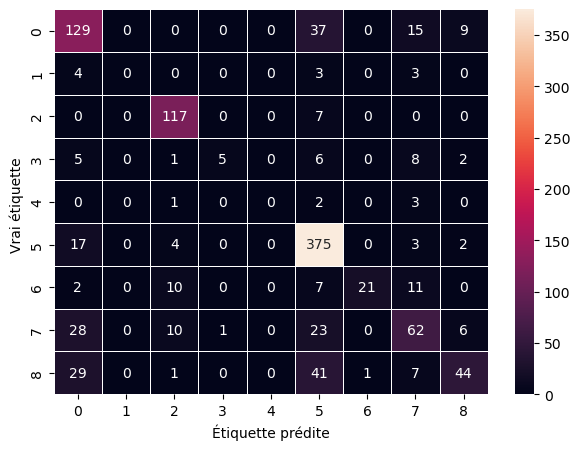

In [43]:
classes = [i for i in range(9)]
result = train_and_test_classifier(train_json_fn, test_json_fn, model='NB', normalization='words')
#disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=classes).plot()
#plt.show()
print(f"Accuracy on train set: {result['accuracy_train']}")
print(f"Accuracy on test set: {result['accuracy_test']}")
display_confusion_matrix(result["confusion_matrix"], classes)

## Section 3 - À quoi correspondent les classes? Explicabilité du modèle

En utilisant les poids des modèles, tentez d'attribuer une signification aux différentes classes. Comme c'est une épreuve d'analyse de données, il est possible que certaines classes ne soient pas interprétables. Vous n'êtes pas tenu à l'impossible. L'important est d'utiliser ce qu'on observe dans les modèles pour fournir une explication.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

## Section 4 - Section réservée pour nos tests (ne pas modifier)